In [1]:
!git clone https://github.com/ivclab/BigGAN-Generator-Pretrained-Pytorch.git

Cloning into 'BigGAN-Generator-Pretrained-Pytorch'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 30 (delta 0), reused 5 (delta 0), pack-reused 25
Unpacking objects: 100% (30/30), done.


In [48]:
os.getcwd()

'/content/BigGAN-Generator-Pretrained-Pytorch'

In [47]:
import os
os.chdir("BigGAN-Generator-Pretrained-Pytorch")

FileNotFoundError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [101]:
!python /content/BigGAN-Generator-Pretrained-Pytorch/demo.py -w '/content/drive/My Drive/BigGAN/biggan256-release.pt' -s 256 -t 0.3 -c 167 
# print("final image: ", final_image)

## **Image Segmentation Model**

In [55]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import models
import torchvision.transforms as T

In [7]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [14]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 0, 0), (0, 0, 0), (255, 255, 255), (0, 0, 0), (0, 0, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (0, 0, 0), (255, 255, 255), (0, 0, 0), (0, 0, 0), (0, 0, 0),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [97]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(256),
                  T.CenterCrop(256),
                  T.ToTensor(),
                  T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  # print("IM seg size", rgb.size)
  # print("IM seg", np.array(rgb).shape)
  # print("rgb is: ",type(rgb))
  plt.imshow(rgb); plt.axis('off'); plt.show()
  return torch.FloatTensor(rgb)

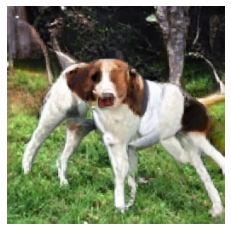

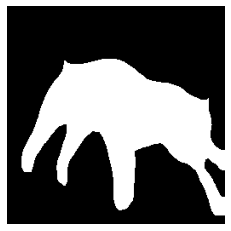

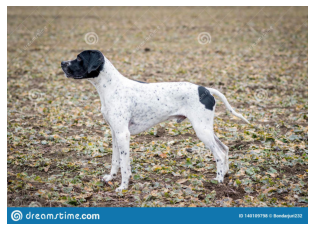

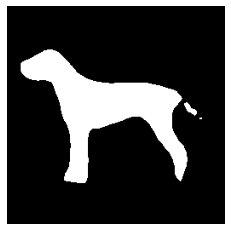

tensor(15148.7617)


In [102]:
pred = segment(dlab, '/content/BigGAN-Generator-Pretrained-Pytorch/image.png')
target = segment(dlab, '/content/BigGAN-Generator-Pretrained-Pytorch/dog_image2.png')

loss = torch.nn.MSELoss()
output = loss(pred, target)
print(output)